In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tensorboardX import SummaryWriter
import logging
import os
import argparse
import seaborn as sns
import matplotlib.pyplot as plt


/home/henrytsui/anaconda3/envs/IDS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("-n", "--name", type=str, default="bert-base-uncased", help="model name")
    parser.add_argument("-e", "--epochs", type=int, default=50)
    parser.add_argument("-b", "--batch-size", type=int, default=128)
    parser.add_argument("--lr", type=float, default=1e-5)
    parser.add_argument("--max-len", type=int, default=64)
    parser.add_argument("-d", "--device", type=str, default="cuda")
    parser.add_argument("--data", type=str, default="../data/train_bert.csv")
    parser.add_argument("--weight", type=str, default="../pretrained/bert_weight.pt")

    return parser

args = make_parser().parse_args(args=[])


In [3]:
class Stock(Dataset):
    def __init__(self, df, model, max_len) -> None:
        self.df = df
        self.score = [float(score) for score in df["score"]]
        self.tokenizer = BertTokenizer.from_pretrained(model)
        self.content = [self.tokenizer(text,padding='max_length', 
                       max_length = max_len, 
                       truncation=True,
                       return_tensors="pt") for text in df["content"]]

    def __getitem__(self, idx):
        return self.score[idx], self.content[idx]

    def __len__(self):
        return self.df.shape[0]

class Bert4price(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.bert = BertModel.from_pretrained(model)
        self.ft_fc = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
        )
        self.vl_fc = nn.Linear(16, 1)
    def forward(self, text, mask):
        _, output = self.bert(input_ids=text, attention_mask=mask,return_dict=False)
        feature = self.ft_fc(output)
        output = self.vl_fc(F.relu(feature))
        return torch.squeeze(feature, 1).double(), torch.squeeze(output, 1).double()

In [4]:
model = Bert4price(args.name)
model = model.to(args.device)
model.load_state_dict(torch.load(args.weight))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Bert4price(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [5]:
merge = pd.read_csv(args.data, index_col=0)

t0, t1, t2 = np.split(merge.sample(frac=1, random_state=42), [int(.8*merge.shape[0]), int(.9*merge.shape[0])])
dataset = {x: Stock(s, args.name, args.max_len) for x, s in [("train", t0), ("valid", t1), ("test", t2)]}
loader = {x: DataLoader(dataset[x], batch_size=args.batch_size, num_workers=24, shuffle=True) 
                                            for x in ["train", "valid", "test"]}

In [6]:
def inference():
    res = dict()
    for state in ["train", "valid", "test"]:
        res[state] = {"emb" : [], "ipt" : [], "opt" : []}
        emb_buf, ipt_buf, opt_buf = [], [], []
        tqdm_bar = tqdm(loader[state], leave=False)
        for value, content in tqdm_bar:
            ipt_buf.append(value.numpy())
            text, mask = content["input_ids"].squeeze(1), content["attention_mask"]
            text, mask = text.to(args.device), mask.to(args.device)
            value = value.to(args.device)
        
            emb, opt = model(text, mask)
            emb = emb.cpu().detach().numpy()
            opt = opt.cpu().detach().numpy()
            emb_buf.append(emb)
            opt_buf.append(opt)
        res[state]["emb"] = np.concatenate(emb_buf)
        res[state]["ipt"] = np.concatenate(ipt_buf)
        res[state]["opt"] = np.concatenate(opt_buf)
    return res
res = inference()

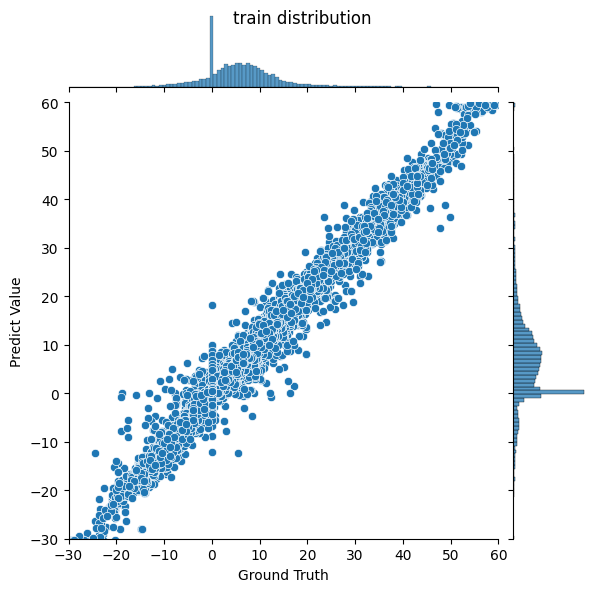

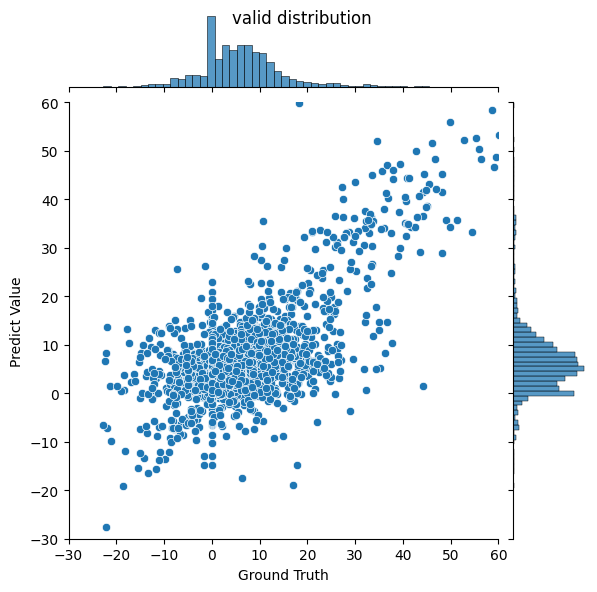

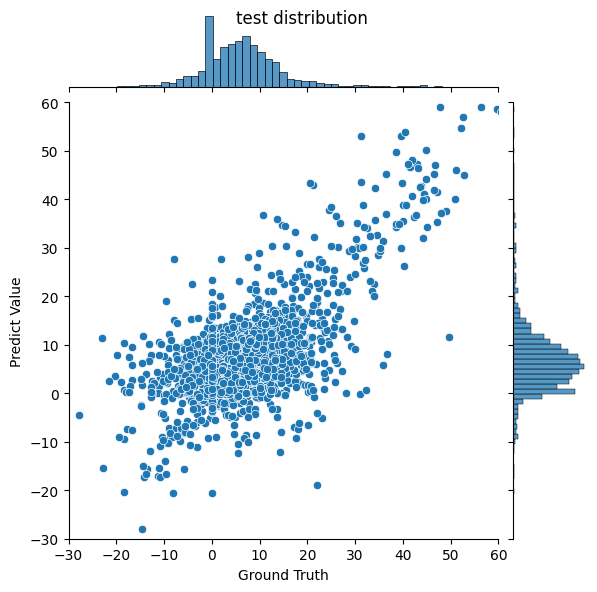

In [13]:
for state in ["train", "valid", "test"]:
    # print(state, F.mse_loss(res[state]["ipt"], res[state]["opt"]))
    plot = sns.jointplot(x="ipt", y="opt", data = res[state])
    plot.ax_marg_x.set_xlim(-30, 60)
    plot.ax_marg_y.set_ylim(-30, 60)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predict Value")
    plot.fig.suptitle(state+ " distribution")
    plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc


In [19]:
fpr, tpr, threshold = roc_curve(res[state]["ipt"], res[state]["opt"])
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

ValueError: continuous format is not supported

ASDF
